# Задача 4. Множинна лінійна регресія для показників Bhutan

У цьому завданні аналізуються соціально-економічні показники однієї країни (Bhutan)
за період 2005–2018 років. Необхідно:
1. Перетворити таблицю так, щоб стовпцями були фактори, а рядками — роки;
2. Обрати цільову змінну та побудувати множинну лінійну регресію;
3. Оцінити якість моделі та зробити висновки.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df4 = pd.read_csv(
    "Task4.csv",
    sep=";",          # головний роздільник у файлі
    decimal=",",      # у числах використано кому замість крапки
    engine="python",  # потрібний для нерівних рядків
    on_bad_lines="skip"  # пропускає зламані рядки
)

df4.head(), df4.shape


(  country_name                                         index_name  \
 0       Sweden       Cause of death, by non-communicable diseases   
 1       Sweden                                      CO2 emissions   
 2       Sweden                              Intentional homicides   
 3       Sweden  Charges for the use of intellectual property, ...   
 4       Sweden                                Import volume index   
 
           2005        2006         2007         2008         2009  \
 0         89.8        89.8         89.8         89.8         89.8   
 1    51561.687   49570.506    48059.702    49123.132    43065.248   
 2          0.9           1          1.2          0.9            1   
 3   1512385256  1690721321   1856019769   2063470051   1855773289   
 4  107.9172739  118.625421  111.0916338  102.9390217  93.34699401   
 
           2010         2011         2012        2013        2014        2015  \
 0         90.7         90.7         90.1        90.1        90.1        89

### Крок 1. Вибір даних для Bhutan

Спочатку відфільтровуємо з загального файлу лише дані для країни Bhutan,
а також переглядаємо, які саме показники (index_name) для неї доступні.
Це дозволить знайти потрібні 6 факторів з умови варіанту.


In [7]:
# Фільтруємо тільки Bhutan
df_bhutan = df4[df4["country_name"] == "Bhutan"].copy()

df_bhutan.shape, df_bhutan["index_name"].unique()


((6, 16),
 array(['Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions',
        'Maternal mortality ratio', 'Gini coefficient',
        'Employment to population ratio, 15+, total',
        ' Industry, value added',
        'Gross national income(GNI), Atlas method'], dtype=object))

### Крок 2. Перетворення таблиці у формат «фактори — стовпці»

У початкових даних кожен показник є окремим рядком, а роки подані у колонках.
Для побудови множинної регресії необхідно, щоб стовпцями були фактори, а
рядками — роки (2005–2018).

Тому:
1. Робимо `index_name` індексом;
2. Транспонуємо таблицю (`.T`);
3. Перетворюємо роки на числові значення;
4. Перейменовуємо стовпці на короткі та читабельні назви.


In [8]:
# Копія з Bhutan
df_bh = df_bhutan.copy()

# Робимо index_name індексом
df_bh = df_bh.set_index("index_name")

# Видаляємо зайві колонки (країна нам більше не треба)
df_bh = df_bh.drop(columns=["country_name"])

# Транспонуємо → тепер роки = рядки
df_bh = df_bh.T

# Перетворюємо назви колонок на короткі
df_bh.columns = [
    "cause_death",
    "maternal_mortality",
    "gini",
    "employment",
    "industry",
    "gni"
]

# Перетворюємо індекс (роки) на int
df_bh.index = df_bh.index.astype(int)

df_bh.head(), df_bh.shape


(     cause_death maternal_mortality  gini   employment     industry  \
 2005        31.8                310  40.9  68.10900116  294206302.9   
 2006        31.8                291  40.9  68.51100159  338476880.7   
 2007        31.8                275  38.1  68.47399902  526904663.3   
 2008        31.8                264  38.1  68.95200348  543581552.6   
 2009        31.8                255  38.1  68.86399841  530776192.4   
 
               gni  
 2005  797661159.7  
 2006  894161136.6  
 2007   1112839719  
 2008   1215682763  
 2009   1296238159  ,
 (14, 6))

In [9]:
# Перевірка типів
df_bh.dtypes


cause_death           object
maternal_mortality    object
gini                  object
employment            object
industry              object
gni                   object
dtype: object

### Крок 3. Приведення типів даних

Після транспонування значення факторів зчитуються як об’єкти (тип `object`),
тому їх потрібно явно привести до числового формату. Для цього видаляємо
зайві пробіли та замінюємо можливі коми на крапки.


In [10]:
# Очищаємо кожен стовпець: прибираємо пробіли, замінюємо коми на крапки
for col in df_bh.columns:
    df_bh[col] = (
        df_bh[col]
        .astype(str)
        .str.replace(",", ".", regex=False)  # заміна ком → крапка
        .str.strip()                         # забираємо пробіли
    )

# Тепер переводимо в float
df_bh = df_bh.astype(float)

df_bh.dtypes, df_bh.head()


(cause_death           float64
 maternal_mortality    float64
 gini                  float64
 employment            float64
 industry              float64
 gni                   float64
 dtype: object,
       cause_death  maternal_mortality  gini  employment     industry  \
 2005         31.8               310.0  40.9   68.109001  294206302.9   
 2006         31.8               291.0  40.9   68.511002  338476880.7   
 2007         31.8               275.0  38.1   68.473999  526904663.3   
 2008         31.8               264.0  38.1   68.952003  543581552.6   
 2009         31.8               255.0  38.1   68.863998  530776192.4   
 
                gni  
 2005  7.976612e+08  
 2006  8.941611e+08  
 2007  1.112840e+09  
 2008  1.215683e+09  
 2009  1.296238e+09  )

### Крок 4. Вибір цільової змінної

Для побудови множинної регресії необхідно обрати залежну змінну (Y).
Згідно з умовою, обираємо фактор із найменшим стандартним відхиленням.


In [11]:
# Рахуємо стандартні відхилення
stds = df_bh.std().sort_values()

stds


gini                  1.069687e+00
employment            2.050018e+00
cause_death           4.633775e+00
maternal_mortality    3.973712e+01
industry              2.200202e+08
gni                   3.492635e+08
dtype: float64

### Крок 5. Кореляційна матриця факторів

Для аналізу мультиколінеарності та взаємозв’язків між змінними будуємо
кореляційну матрицю. Це дозволить визначити, чи існує математична або
змістовна залежність між факторами.


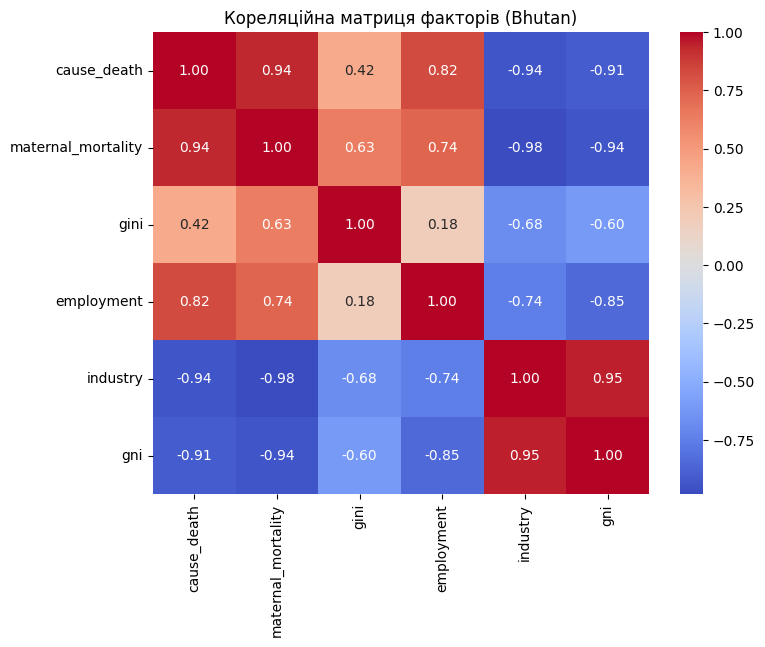

,cause_death,maternal_mortality,gini,employment,industry,gni
cause_death,1.000000,0.935320,0.418549,0.822150,-0.937992,-0.908983
maternal_mortality,0.935320,1.000000,0.634024,0.735159,-0.982663,-0.940867
gini,0.418549,0.634024,1.000000,0.184580,-0.680092,-0.603818
employment,0.822150,0.735159,0.184580,1.000000,-0.742659,-0.847944
industry,-0.937992,-0.982663,-0.680092,-0.742659,1.000000,0.948680
gni,-0.908983,-0.940867,-0.603818,-0.847944,0.948680,1.000000


In [12]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_bh.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Кореляційна матриця факторів (Bhutan)")
plt.show()

df_bh.corr()


In [13]:
df_bh


,cause_death,maternal_mortality,gini,employment,industry,gni
2005,31.8,310.0,40.9,68.109001,2.942063e+08,7.976612e+08
2006,31.8,291.0,40.9,68.511002,3.384769e+08,8.941611e+08
2007,31.8,275.0,38.1,68.473999,5.269047e+08,1.112840e+09
2008,31.8,264.0,38.1,68.952003,5.435816e+08,1.215683e+09
2009,31.8,255.0,38.1,68.863998,5.307762e+08,1.296238e+09
2010,26.0,247.0,38.1,67.508003,6.782496e+08,1.430203e+09
2011,26.0,239.0,38.1,65.779999,7.459686e+08,1.592500e+09
2012,24.2,231.0,38.8,64.216003,7.589826e+08,1.721748e+09
2013,24.2,223.0,38.8,64.200996,7.616165e+08,1.758632e+09
2014,24.2,214.0,38.8,62.692001,7.943528e+08,1.758632e+09


In [15]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings

# Глушимо всі попередження від scipy.stats про n<20
warnings.filterwarnings(
    "ignore",
    message="`kurtosistest` p-value may be inaccurate with fewer than 20 observations"
)

df = df_bh.copy()

# Модель A
X_A = df[["employment", "cause_death"]]
X_A = sm.add_constant(X_A)
y = df["gini"]

model_A = sm.OLS(y, X_A).fit()
print("=== МОДЕЛЬ A ===")
print(model_A.summary())

# VIF
vif_A = pd.DataFrame()
vif_A["factor"] = X_A.columns
vif_A["VIF"] = [variance_inflation_factor(X_A.values, i) for i in range(X_A.shape[1])]
print("\n=== VIF (Model A) ===")
print(vif_A)


=== МОДЕЛЬ A ===
                            OLS Regression Results                            
Dep. Variable:                   gini   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     1.870
Date:                Mon, 01 Dec 2025   Prob (F-statistic):              0.200
Time:                        09:44:22   Log-Likelihood:                -18.241
No. Observations:                  14   AIC:                             42.48
Df Residuals:                      11   BIC:                             44.40
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          50.6940     13.645

In [17]:
# Модель B
X_B = df[["employment", "maternal_mortality"]]
X_B = sm.add_constant(X_B)

model_B = sm.OLS(y, X_B).fit()
print("\n=== МОДЕЛЬ B ===")
print(model_B.summary())

# VIF
vif_B = pd.DataFrame()
vif_B["factor"] = X_B.columns
vif_B["VIF"] = [variance_inflation_factor(X_B.values, i) for i in range(X_B.shape[1])]
print("\n=== VIF (Model B) ===")
print(vif_B)



=== МОДЕЛЬ B ===
                            OLS Regression Results                            
Dep. Variable:                   gini   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     7.425
Date:                Mon, 01 Dec 2025   Prob (F-statistic):            0.00910
Time:                        09:45:40   Log-Likelihood:                -14.309
No. Observations:                  14   AIC:                             34.62
Df Residuals:                      11   BIC:                             36.53
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const             

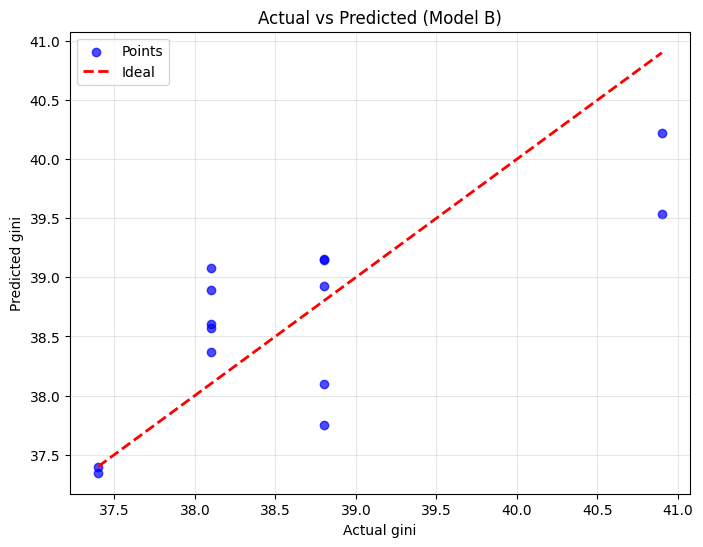

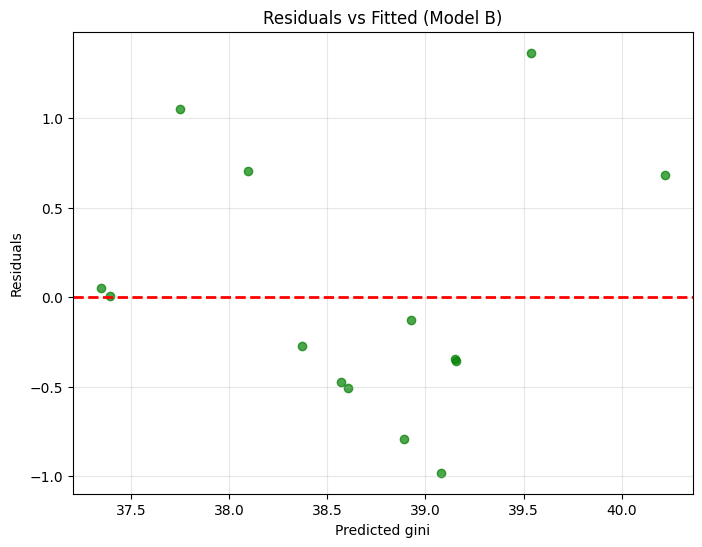

<Figure size 800x600 with 0 Axes>

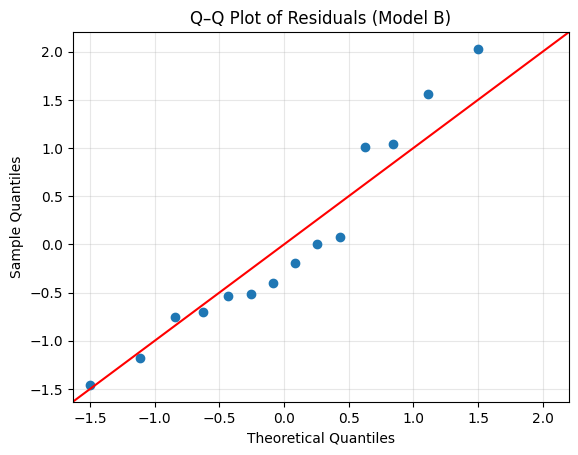

In [20]:

import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# --------- 1. Витягуємо лише правильні дані ---------
y = bhutan_factors["gini"]
X_B = bhutan_factors[["employment", "maternal_mortality"]]
X_B = sm.add_constant(X_B)

# --------- 2. Прогноз ---------
y_pred_B = model_B.predict(X_B)
residuals_B = y - y_pred_B


# =====================================================
# 1) Actual vs Predicted
# =====================================================
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred_B, color="blue", alpha=0.7, label="Points")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", linewidth=2, label="Ideal")
plt.xlabel("Actual gini")
plt.ylabel("Predicted gini")
plt.title("Actual vs Predicted (Model B)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# =====================================================
# 2) Residuals vs Fitted
# =====================================================
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_B, residuals_B, color="green", alpha=0.7)
plt.axhline(0, color="red", linestyle="--", linewidth=2)
plt.xlabel("Predicted gini")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Model B)")
plt.grid(True, alpha=0.3)
plt.show()


# =====================================================
# 3) Q–Q Plot
# =====================================================
plt.figure(figsize=(8, 6))
sm.qqplot(residuals_B, line="45", fit=True)
plt.title("Q–Q Plot of Residuals (Model B)")
plt.grid(True, alpha=0.3)
plt.show()


У ході аналізу даних для Бутану було побудовано множинні лінійні регресійні моделі з метою прогнозування показника **Gini** (фактор із найменшим стандартним відхиленням). Попередній кореляційний аналіз показав наявність сильних економічно та змістовно обґрунтованих зв’язків між факторами (*industry – gni*, *mortality – cause_death* тощо).  

Для уникнення мультиколінеарності з моделі були вилучені найбільш корельовані фактори.

Найкращою з побудованих моделей стала модель:

$$
\text{Gini} = \beta_0 + \beta_1 \cdot \text{employment} + \beta_2 \cdot \text{maternal\ mortality}
$$

Модель є статистично значущою (**F-test p = 0.009**), пояснює **57.4%** варіації показника (**R² = 0.574**), параметри не демонструють мультиколінеарності (**VIF ≈ 2.17**), а розподіл залишків є нормальним (**Omnibus p > 0.4**).  

Таким чином, модель коректно відтворює залежність показника **Gini** від рівня зайнятості та материнської смертності і може бути використана для подальшого аналізу.
